This notebook calculates the correlation between reflux variables and lung-gastric beta diversity and makes the respective figure.

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Prepare data

First, we'll massage the tidy JSD file such that the reflux metadata is also in tidy format. Currently, the different reflux metrics are each their own column. For easier plotting, we'll make variable and value columns where the variable is the type of reflux metric and the value is the value for that type of reflux metric.

In [14]:
fnjsd = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'

jsd = pd.read_csv(fnjsd, sep='\t').dropna(how='all', axis=1)
print(jsd.shape)
print(jsd.columns)
jsd.head()

(103285, 36)
Index([u'sample1', u'sample2', u'beta', u'site1', u'site2', u'site_comparison',
       u'patient_comp', u'subject', u'batch1', u'batch2',
       u'Results of MBS closest to enrollment date', u'Results of worst MBS',
       u'mbs_consolidated', u'ppi_consolidated', u'Patient taking PPI',
       u'Patient taking PPI?', u'ACIDSUP',
       u'Reflux - total number of episodes', u'Number of acid reflux episodes',
       u'Total number of reflux episodes (acid+non-acid)', u'SI - Reflux',
       u'SSI - Reflux', u'SAP - Reflux', u'Number of non-acid reflux episodes',
       u'percent distal nonacid', u'percent proximal total',
       u'percent distal acid', u'percent proximal acid',
       u'percent proximal nonacid', u'percent distal total',
       u'number of full colum events/total events',
       u'Number of full column episodes', u'Was Bile CA detected?',
       u'Was Bile DCA detected?', u'Was Bile LCA detected?',
       u'Was Bile TCA detected?'],
      dtype='object')


,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,...,percent distal acid,percent proximal acid,percent proximal nonacid,percent distal total,number of full colum events/total events,Number of full column episodes,Was Bile CA detected?,Was Bile DCA detected?,Was Bile LCA detected?,Was Bile TCA detected?
0,01-112-7GI,01-112-7RI,0.400324,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-112-7GI,01-112-7TI,0.993353,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-112-7GI,01-164-7GI,0.994055,gastric_fluid,gastric_fluid,gastric_fluid-gastric_fluid,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-112-7GI,01-164-7RI,0.575080,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-112-7GI,01-164-7TI,0.995439,gastric_fluid,throat_swab,gastric_fluid-throat_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
## Metadata column edits

# Note: there are additional reflux metadata columns, but these are the
# ones with the most reliable measurements
refluxcols = ['Total number of reflux episodes (acid+non-acid)',
              'number of full colum events/total events',
              'percent proximal total',
              'percent distal total']
# Clean up the reflux cols
jsd[refluxcols] = jsd[refluxcols].replace('n/a', np.nan)
jsd[refluxcols] = jsd[refluxcols].astype(float)
# Some missing entries are wrongly entered as 1
jsd['number of full colum events/total events'] = jsd['number of full colum events/total events'].replace(1, np.nan)

# And replace nan's with "nan" strings for aspiration status
jsd['mbs_consolidated'] = jsd['mbs_consolidated'].fillna('Not tested')

In [16]:
# Multiple the percent columns by 100 to get into values of percentage
jsd['percent proximal total'] = 100*jsd['percent proximal total']
jsd['percent distal total'] = 100*jsd['percent distal total']

In [17]:
## Only consider within-patient comparisons
jsd = jsd.query('patient_comp == "within"')

## Keep only comparisons from the same time point
jsd = jsd[
    ~(  jsd['sample1'].str.endswith('F') 
      | jsd['sample2'].str.endswith('F')
      | jsd['sample1'].str.endswith('2')
      | jsd['sample2'].str.endswith('2')
      | jsd['sample1'].str.endswith('F2T')
      | jsd['sample2'].str.endswith('F2T')
      | jsd['sample1'].str.endswith('sick')
      | jsd['sample2'].str.endswith('sick')
      | jsd['sample1'].str.startswith('05')
      | jsd['sample2'].str.startswith('05')
     )]

print(jsd.shape)

(307, 36)


Like I mentioned in the PCA notebook, I've moved these checks into the actual JSD calculation script. I'll leave this here though, just for future sanity check. The code that does this is in `src/analysis/jsd.py`:

```
# Don't include samples from second time point or lung transplants
exclude = ['2', 'F', 'sick', 'F2T']
for s in exclude:
    samples = [i for i in samples if not i.endswith(s)]
samples = [i for i in samples if not i.startswith('05')]
```

In [18]:
idvars = ['sample1', 'sample2', 'beta', 'site1', 'site2', 
          'site_comparison', 'patient_comp', 'subject', 
          'batch1', 'batch2', 'mbs_consolidated']
tidyjsd = pd.melt(jsd, value_vars=refluxcols, 
                  var_name='reflux_type', value_name='reflux_value',
                  id_vars=idvars)
tidyjsd.dropna().head()

,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,mbs_consolidated,reflux_type,reflux_value
21,02-096-6G,02-096-6T,0.944147,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,02-096-6,2014,2014,Normal,Total number of reflux episodes (acid+non-acid),54.0
22,02-098-5B,02-098-5G,0.243337,bal,gastric_fluid,bal-gastric_fluid,within,02-098-5,2014,2014,Normal,Total number of reflux episodes (acid+non-acid),66.0
23,02-098-5B,02-098-5T,0.975509,bal,throat_swab,bal-throat_swab,within,02-098-5,2014,2014,Normal,Total number of reflux episodes (acid+non-acid),66.0
24,02-098-5G,02-098-5T,0.981589,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,02-098-5,2014,2014,Normal,Total number of reflux episodes (acid+non-acid),66.0
25,02-099-7B,02-099-7G,0.286062,bal,gastric_fluid,bal-gastric_fluid,within,02-099-7,2014,2014,Not tested,Total number of reflux episodes (acid+non-acid),25.0


# Make plot

In [19]:
asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'Not tested': '#C9C9C9'}
hue_order = ['Normal', 'Aspiration/Penetration', 'Not tested']

# Only interested in the bal-gastric relationship
toplot = tidyjsd.query('site_comparison == "bal-gastric_fluid"')

# And drop any samples without the reflux actually measured
toplot = toplot.dropna(subset=['beta', 'reflux_value'])

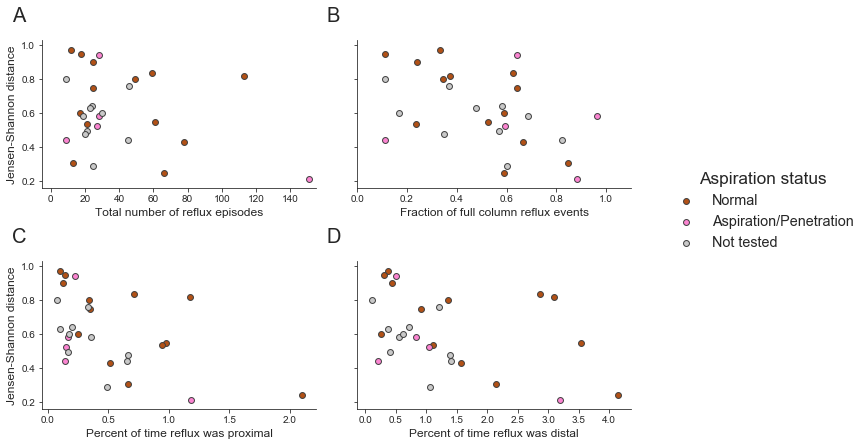

In [20]:
sns.set_style('ticks')
g = sns.FacetGrid(
    data=toplot, 
    col='reflux_type', col_wrap=2, 
    hue='mbs_consolidated', hue_order=hue_order,
    sharex=False, legend_out=True, palette=asp_colors,
    aspect=1.5)
scatter_kwargs = {'s' : 35, 'edgecolors': '0.25'}
g.map(plt.scatter, 'reflux_value', 'beta', **scatter_kwargs).set_titles("{col_name}")

# Axes limits
g.facet_axis(0, 0).set_xlim([-5, 155])
g.facet_axis(0, 1).set_xlim([0, 1.1])
#g.facet_axis(0, 2).set_xlim([-0.002, 0.024])
#g.facet_axis(0, 3).set_xlim([-0.002, 0.049])

# X and Y axis labels
g.facet_axis(0, 0).set_ylabel('Jensen-Shannon distance', fontsize='large')
g.facet_axis(0, 2).set_ylabel('Jensen-Shannon distance', fontsize='large')

g.facet_axis(0, 2).set_xlabel('')
g.facet_axis(0, 3).set_xlabel('')

# Legend, anchored to top right axis
lgd = g.facet_axis(0, 1)\
    .legend(bbox_to_anchor=(1.1, 0.2), 
            loc='upper left', fontsize='x-large',
            frameon=False)
lgd.set_title('Aspiration status', prop={'size': 'xx-large'})

# Remove titles
g.set_titles('')
#g.facet_axis(0, 1).set_xlabel('Percentage of full column reflux events', **title_kwargs)
#g.facet_axis(0, 2).set_xlabel('Percent of time reflux was proximal', **title_kwargs)
#g.facet_axis(0, 3).set_xlabel('Percent of time reflux was distal', **title_kwargs)

# X-labels
title_kwargs = {'fontsize': 'large'}
g.facet_axis(0, 0).set_xlabel('Total number of reflux episodes', **title_kwargs)
g.facet_axis(0, 1).set_xlabel('Fraction of full column reflux events', **title_kwargs)
g.facet_axis(0, 2).set_xlabel('Percent of time reflux was proximal', **title_kwargs)
g.facet_axis(0, 3).set_xlabel('Percent of time reflux was distal', **title_kwargs)

# A, B, C, D labels
lbls = ['A', 'B', 'C', 'D']
for i in [0, 1, 2, 3]:
    a = g.facet_axis(0, i)
    a.text(-0.11, 1.125, lbls[i], transform=a.transAxes, fontsize=20)
#txt = ax.text(-0.11, 1.025, 'A', transform=ax.transAxes, fontsize=24)

plt.subplots_adjust(hspace=0.5, wspace=0.15)

plt.savefig('../../final/figures/figure5.reflux_correlations.png', 
           bbox_inches='tight', #bbox_extra_artists=(lgd),
           dpi=200)

# Calculate correlations

Next, we'll calculate the actual correlations for each of these reflux measures.

In [21]:
from scipy.stats import spearmanr, pearsonr

## Spearman correlation
for r, subdf in toplot.groupby('reflux_type'):
    print(r, spearmanr(subdf['reflux_value'], subdf['beta']))

('Total number of reflux episodes (acid+non-acid)', SpearmanrResult(correlation=-0.14299417611920817, pvalue=0.46790021918957314))
('number of full colum events/total events', SpearmanrResult(correlation=-0.4081018239941703, pvalue=0.031093111623939913))
('percent distal total', SpearmanrResult(correlation=-0.43185550082101803, pvalue=0.02174347680468858))
('percent proximal total', SpearmanrResult(correlation=-0.47181171319102355, pvalue=0.011252594822857453))


In [22]:
## Pearson correlation of the log
for r, subdf in toplot.groupby('reflux_type'):
    print(r, pearsonr(np.log10(subdf['reflux_value']), np.log10(subdf['beta'])))

('Total number of reflux episodes (acid+non-acid)', (-0.2506371208961543, 0.19829296614482395))
('number of full colum events/total events', (-0.3969190725071192, 0.03649876709652478))
('percent distal total', (-0.4482097651465254, 0.016755551799854145))
('percent proximal total', (-0.5459453807843117, 0.002653747802547115))


# Patients

Get the list of patients used in making this figure

In [23]:
toplot.groupby(['reflux_type', 'mbs_consolidated']).size()

reflux_type                                      mbs_consolidated      
Total number of reflux episodes (acid+non-acid)  Aspiration/Penetration     5
                                                 Normal                    13
                                                 Not tested                10
number of full colum events/total events         Aspiration/Penetration     5
                                                 Normal                    13
                                                 Not tested                10
percent distal total                             Aspiration/Penetration     5
                                                 Normal                    13
                                                 Not tested                10
percent proximal total                           Aspiration/Penetration     5
                                                 Normal                    13
                                                 Not tested           

In [24]:
toplot['subject'].unique().shape

(28,)

In [25]:
## A note for this file: I used bal and gastric samples from these patients
#with open('../../final/patients/figure5.reflux_correlation.subjects.txt', 'w') as f:
#    f.write('\n'.join(toplot['subject'].unique()) + '\n')

In [26]:
samples = toplot['sample1'].tolist() + toplot['sample2'].tolist()
print(len(samples), len(set(samples)))

(224, 56)


In [27]:
samples = list(set(samples))
with open('../../data/patients/figure5.reflux_correlation.samples.txt', 'w') as f:
    f.write('\n'.join(samples))